# Tracking and Bidding with MultiPeriodRankine in Prescient
This notebook demonstrates how to perform tracking and bidding in a Prescient simulation using the IDAES `MultiPeriodRankine` object. More specifically, it demonstrates how `Tracker` and `Bidder` Python objects are used to solve optimization problems that correspond to a generator *tracking* a dispatch signal and *bidding* in the electricity market based on forecasts of locational marginal price (LMP).

The `MultiPeriodRankine` model uses the IDAES steady state Rankine cycle located at `idaes.apps.rankine.simple_rankine_cycle` 
as well as the multiperiod module to formulate a multi-period version of the steady state problem located at: 
`idaes.apps.grid_integration.multiperiod.multiperiod.MultiPeriodModel` 

The `MultiPeriodRankine` model contains prominent features and constraints in addition to the simple Rankine cycle such as battery storage and ramping constraints which are incorporated using the multiperiod module. 

## Getting Started
To get this notebook example started, we need to import necessary Python packages. These consist of pyomo (to get access to solvers), the bidding and tracking IDAES objects, as well as the IDAES `MultiPeriodRankine` object.

In [1]:
import pyomo.environ as pyo
import numpy as np
from idaes.apps.grid_integration.tracker import Tracker
from idaes.apps.grid_integration.bidder import Bidder
from idaes.apps.grid_integration.examples.multiperiod_rankine.multiperiod_double_loop_rankine import MultiPeriodRankine

    Import ComponentMap from pyomo.common.collections.  (deprecated in 5.7.1)
    (called from <frozen importlib._bootstrap>:219)
    Import ComponentSet from pyomo.common.collections.  (deprecated in 5.7.1)
    (called from <frozen importlib._bootstrap>:219)
Interactive Python mode detected; using default matplotlib backend for plotting.


## Tracking with MultiPeriodRankine
This cell sets up a simple tracking problem with a 4-hour prediction horizon with minimum and maximum generation limits of 30 MW and 76 MW respectively. 

In [2]:
#prediction horizon used for tracking
tracking_horizon = 4 

#generation limits
pmin = 30.0 
pmax = 76.0 
mp_rankine_track = MultiPeriodRankine(tracking_horizon, pmin=pmin, pmax=pmax)

Create a `Tracker` object and solve an optimization problem to track a 4-hour dispatch signal

In [3]:
n_tracking_hour = 1  #frequency we perform tracking (e.g. 1 mean at each hourly interval)
solver = pyo.SolverFactory("ipopt")

#create a `Tracker` using`mp_rankine_track`
tracker_object = Tracker(
    tracking_model_object=mp_rankine_track,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

#example market dispatch signal for 4 hours
market_dispatch = [30, 40, 50, 70]

#find a solution that tracks the dispatch signal
tracker_object.track_market_dispatch(
    market_dispatch=market_dispatch,date="2021-07-26", hour="17:00"
)

#The tracked power output
for t in range(4):
    print(t, pyo.value(tracker_object.power_output[t]))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Bidding with MultiPeriodRankine
These cells set up a simple bidding problem with a 4-hour prediction horizon and 3 separate price scenarios. It uses the generation limits as the tracking problem above.

In [4]:
class SimpleForecaster:
    def __init__(self, horizon, n_sample):
        self.horizon = horizon
        self.n_sample = n_sample

    def forecast(self, date, hour, prediction):
        return {i: [prediction] * self.horizon for i in range(self.n_sample)}

In [5]:
bidding_horizon = 4
n_scenario = 3
pmin = 30.0 
pmax = 76.0 
mp_rankine_bid = MultiPeriodRankine(horizon=bidding_horizon, pmin=pmin, pmax=pmax)

In [6]:
solver = pyo.SolverFactory("ipopt")

bidder_object = Bidder(
    bidding_model_object=mp_rankine_bid,
    n_scenario=n_scenario,
    solver=solver,
    forecaster=SimpleForecaster(horizon=bidding_horizon, n_sample=n_scenario),
)

date = "2021-08-20"
bids = bidder_object.compute_bids(date=date,hour=None,prediction=31.0)
print(bids)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Creating a Prescient Plugin
The following cell creates a Prescient plugin file to perform bidding a tracking using the presented bidding and tracking objects. It further uses the IDAES grid integration `PlaceHolderForecaster` and `DoubleLoopCoordinator` objects which manage the underlying bidding and tracking objects.

In [7]:
%%writefile plugin_prescient_mp_rankine.py

import pickle
import pandas as pd
import pyomo.environ as pyo
from pyomo.common.config import ConfigDict, ConfigValue
from pyomo.common.fileutils import this_file_dir

from idaes.apps.grid_integration.tracker import Tracker
from idaes.apps.grid_integration.bidder import Bidder
from idaes.apps.grid_integration.forecaster import PlaceHolderForecaster
from idaes.apps.grid_integration.coordinator import DoubleLoopCoordinator

from multiperiod_double_loop_rankine import MultiPeriodRankine

with open('generator_data.pkl', 'rb') as f:
    gen_data = pickle.load(f)

default_bid_curve = gen_data['Original Marginal Cost Curve']
pmin = gen_data['PMin MW']
pmax = gen_data['PMax MW']
gen_name = gen_data['generator_name']

tracking_horizon = 4  #hours
bidding_horizon = 48  #hours
n_scenario = 3       #for bidding
n_tracking_hour = 1   #advance n_tracking_hour (i.e. assume we solve every hour)

# create forecaster
price_forecasts_df = pd.read_csv(this_file_dir()+'/../lmp_forecasts_concat.csv')
forecaster = PlaceHolderForecaster(price_forecasts_df = price_forecasts_df)

# create solver
solver = pyo.SolverFactory('ipopt')

#################################################################################
#Setup trackers, bidder, and coordinator
#################################################################################
#Tracker
mp_rankine_tracker = MultiPeriodRankine(horizon=tracking_horizon, pmin=pmin, pmax=pmax, 
    default_bid_curve=default_bid_curve, generator_name=gen_name)
thermal_tracker = Tracker(tracking_model_object = mp_rankine_tracker,\
                          n_tracking_hour = n_tracking_hour, \
                          solver = solver)

#Projection Tracker
mp_rankine_projection_tracker = MultiPeriodRankine(horizon=tracking_horizon, pmin=pmin, pmax=pmax, 
    default_bid_curve=default_bid_curve, generator_name=gen_name)
thermal_projection_tracker = Tracker(tracking_model_object=mp_rankine_projection_tracker,\
                                     n_tracking_hour=n_tracking_hour, \
                                     solver=solver)

#Bidder
mp_rankine_bidder= MultiPeriodRankine(horizon=bidding_horizon, pmin=pmin, pmax=pmax, 
    default_bid_curve=default_bid_curve, generator_name=gen_name)
thermal_bidder = Bidder(bidding_model_object=mp_rankine_bidder,\
                        n_scenario=n_scenario,\
                        solver=solver,\
                        forecaster=forecaster)

#Coordinator
coordinator = DoubleLoopCoordinator(bidder=thermal_bidder,\
                                    tracker=thermal_tracker,\
                                    projection_tracker=thermal_projection_tracker)

## Prescient requires the following functions in this module
get_configuration = coordinator.get_configuration
register_plugins = coordinator.register_plugins

Overwriting plugin_prescient_mp_rankine.py


This cell executes the Prescient simulator. It requires the user to have the Python Prescient package available from https://github.com/grid-parity-exchange/Prescient and the RTS-GMLC data-set (https://github.com/GridMod/RTS-GMLC). The user must point to the location of RTS-GMLC scenarios using `rts_gmlc_data_dir`.

The following simulation run for 1 day with an economic-dispatch horizon of 4 hours and unit-committment horizon of 48 hours. The plugin file gets called throughout the simulation to perform bidding and to track the dispatch signal for generator '102_STEAM_3'.

In [8]:
from prescient.simulator import Prescient

#point to rts_gmlc scenario data
rts_gmlc_data_dir = "/home/xgao1/DowlingLab/RTS-GMLC/RTS_Data/SourceData"

options = {'data_path': rts_gmlc_data_dir,\
           'input_format': 'rts-gmlc',
           'simulate_out_of_sample': True,\
           'run_sced_with_persistent_forecast_errors': True,\
           'output_directory': 'bidding_plugin_test_multiperiod_rankine',\
           'start_date':'07-11-2020',\
           'num_days': 1,\
           'sced_horizon':4,\
           'ruc_horizon':48,\
           'compute_market_settlements': True,\
           'day_ahead_pricing': 'LMP',\
           'ruc_mipgap':0.01,\
           'symbolic_solver_labels': True,\
           'reserve_factor':0.0,\
           'deterministic_ruc_solver':'cbc',\
           'sced_solver':'cbc',\
           'plugin': {'doubleloop': {'module': 'plugin_prescient_mp_rankine.py',\
                                      'bidding_generator': '102_STEAM_3'}}\
            }

Prescient().simulate(**options)


Initializing simulation...


/home/xgao1/miniconda3/envs/prescient_and_idaes/lib/python3.7/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


Setting default t0 state in RTS-GMLC parser
Dates to simulate: 2020-07-11 to 2020-07-11
RUC activation hours: 0
Final RUC date: 2020-07-11
Using current day's forecasts for RUC solves
Using persistent forecast error model when projecting demand and renewables in SCED


Extracting scenario to simulate
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran cod

  68 -4.1539666e+04 1.19e-07 5.86e+03  -1.0 1.18e+08    -  2.50e-01 5.73e-01f  1
  69 -4.2326049e+04 1.19e-07 4.35e+03  -1.0 1.29e+08    -  2.57e-01 8.39e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.2477432e+04 1.19e-07 3.42e+03  -1.0 1.01e+08    -  2.14e-01 5.05e-01f  1
  71 -4.2542153e+04 1.19e-07 2.45e+03  -1.0 1.02e+08    -  2.85e-01 2.68e-01f  1
  72 -4.2572145e+04 1.19e-07 2.12e+03  -1.0 1.35e+08    -  1.35e-01 1.28e-01f  1
  73 -4.2723854e+04 1.19e-07 1.45e+03  -1.0 1.19e+08    -  3.14e-01 7.24e-01f  1
  74 -4.2811679e+04 1.19e-07 1.12e+03  -1.0 1.51e+08    -  2.31e-01 9.92e-01f  1
  75 -4.2819747e+04 1.19e-07 7.07e+02  -1.0 8.12e+07    -  3.68e-01 4.74e-01f  1
  76 -4.2833556e+04 1.19e-07 6.72e+00  -1.0 9.83e+07    -  9.90e-01 1.00e+00f  1
  77 -4.2875158e+04 1.19e-07 1.81e+06  -2.5 6.68e+06    -  9.30e-01 7.44e-01f  1
  78 -4.2887391e+04 1.19e-07 3.59e+05  -2.5 1.57e+06    -  1.00e+00 8.56e-01f  1
  79 -4.2889428e+04 1.19e-07

  18  7.4134836e+03 1.06e+04 8.42e-01  -1.0 1.24e+06    -  9.00e-01 1.00e+00h  1
  19  7.4137756e+03 1.19e-07 8.90e-03  -1.0 1.06e+04    -  9.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.4137185e+03 5.96e-08 1.12e-02  -1.0 6.47e+03    -  9.88e-01 3.72e-01f  2
  21  7.3989373e+03 5.96e-08 2.27e-03  -1.0 6.26e+05    -  8.54e-01 1.00e+00f  1
  22  6.5931264e+03 1.19e-07 2.65e-02  -1.0 5.29e+07    -  9.90e-02 8.33e-01f  1
  23  6.4422924e+03 7.45e-08 2.42e-02  -1.0 4.23e+07    -  3.34e-01 1.79e-01f  1
  24  6.3903044e+03 5.96e-08 1.25e-01  -1.0 1.56e+07    -  9.91e-01 3.42e-01f  1
  25  6.2962360e+03 5.96e-08 7.89e-07  -1.7 4.44e+06    -  1.00e+00 1.00e+00f  1
  26  6.2733581e+03 5.96e-08 1.64e-07  -2.5 3.86e+06    -  1.00e+00 1.00e+00f  1
  27  6.2698320e+03 5.96e-08 8.07e-09  -3.8 1.16e+06    -  1.00e+00 1.00e+00f  1
  28  6.2696371e+03 7.45e-08 9.22e-11  -5.7 2.39e+05    -  1.00e+00 1.00e+00f  1
  29  6.2696347e+03 7.45e-08

Fixed costs:        44987.29
Variable costs:     32808.82

Number on/offs:                  0
Sum on/off ramps:             0.00
Sum nominal ramps:          241.70

Simulating time_step  2020-07-11 02:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        40049.40
Variable costs:     28948.10

Number on/offs:                  0
Sum on/off ramps:             0.00
Sum nominal ramps:           86.32

Simulating time_step  2020-07-11 04:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        30868.05
Variable costs:     31471.41

Number on/offs:                  2
Sum on/off ramps:             0.00
Sum nominal ramps:          283.86

Simulating time_step  2020-07-11 06:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        26444.07
Variable costs:     18214.15

Number on/offs:                  0
Sum on/off ramps:             0.00
Sum nominal ramps:          276.77

Simulating time_step  2020-07-11 08:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        32500.14
Variable costs:     16224.72

Number on/offs:                  4
Sum on/off ramps:           170.00
Sum nominal ramps:          143.98

Simulating time_step  2020-07-11 10:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        40942.64
Variable costs:     19242.23

Number on/offs:                  4
Sum on/off ramps:           170.00
Sum nominal ramps:           40.83

Simulating time_step  2020-07-11 12:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        50405.36
Variable costs:     23067.77

Number on/offs:                  4
Sum on/off ramps:           170.00
Sum nominal ramps:          119.36

Simulating time_step  2020-07-11 14:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        65716.67
Variable costs:     31850.84

Number on/offs:                  5
Sum on/off ramps:           340.00
Sum nominal ramps:          284.95

Simulating time_step  2020-07-11 16:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        65155.74
Variable costs:     41702.43

Number on/offs:                  3
Sum on/off ramps:             0.00
Sum nominal ramps:          172.59

Simulating time_step  2020-07-11 18:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        65155.74
Variable costs:     48091.09

Number on/offs:                  3
Sum on/off ramps:             0.00
Sum nominal ramps:           71.07

Simulating time_step  2020-07-11 20:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        65155.74
Variable costs:     42277.09

Number on/offs:                  3
Sum on/off ramps:             0.00
Sum nominal ramps:          239.74

Simulating time_step  2020-07-11 22:00

Solving SCED instance
Solving for LMPs
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All techni

Fixed costs:        50230.29
Variable costs:     41976.29

Number on/offs:                  5
Sum on/off ramps:             0.00
Sum nominal ramps:          290.20


Saving bidding results to disk...

Saving tracking results to disk...
Simulation Complete
Total simulation time: 189.25 seconds


In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
result_data_dir = 'bidding_plugin_test_multiperiod_rankine'

bidding_df = pd.read_csv(os.path.join(result_data_dir,'bidder_detail.csv'))

In [10]:
# sort bid profile columns
bid_time = bidding_df["Hour"]
bid_profiles = bidding_df.iloc[:,3:-1]
bid_profiles_sorted = bid_profiles.reindex(sorted(bid_profiles.columns), axis=1)

In [11]:
# look at the bidding data
bid_profiles_sorted

,Cost 0 [$],Cost 1 [$],Cost 2 [$],Cost 3 [$],Cost 4 [$],Power 0 [MW],Power 1 [MW],Power 2 [MW],Power 3 [MW],Power 4 [MW],Power 5 [MW]
0,633.900000,660.369000,1084.853333,1535.806667,1986.760000,30.0,30.900000,45.333333,60.666667,76.0,NaN
1,735.097743,1018.206102,1337.845618,1683.092600,3059.093600,30.0,45.333333,60.666667,76.000000,121.1,NaN
2,735.097743,1018.206102,1337.845618,1683.092600,1703.357096,30.0,45.333333,60.666667,76.000000,76.9,NaN
3,569.700000,852.808359,1172.447875,1517.694857,2973.001857,30.0,45.333333,60.666667,76.000000,122.9,NaN
4,430.800000,713.908359,1033.547875,1378.794857,2668.174857,30.0,45.333333,60.666667,76.000000,122.0,NaN
5,735.097743,1018.206102,1337.845618,1683.092600,NaN,30.0,45.333333,60.666667,76.000000,NaN,NaN
6,735.097743,1018.206102,1337.845618,1683.092600,1703.357096,30.0,45.333333,60.666667,76.000000,76.9,122.9
7,202.500000,485.608359,805.247875,1150.494857,NaN,30.0,45.333333,60.666667,76.000000,NaN,NaN
8,735.097743,1018.206102,1337.845618,1683.092600,NaN,30.0,45.333333,60.666667,76.000000,NaN,NaN
9,735.097743,1018.206102,1337.845618,1683.092600,NaN,30.0,45.333333,60.666667,76.000000,NaN,NaN


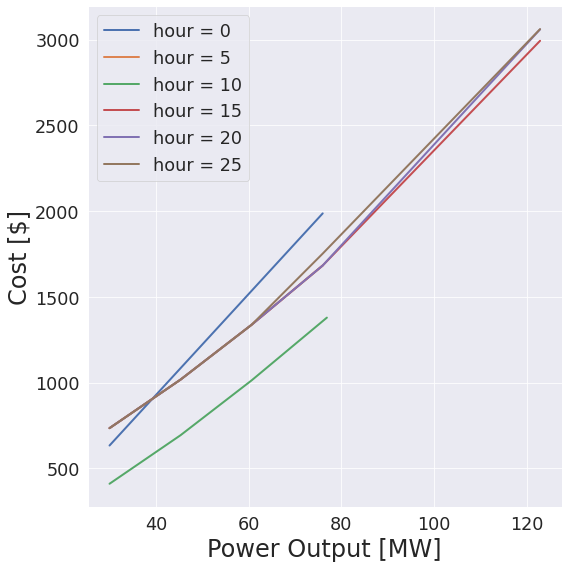

In [12]:
# plot snapshot of bid curves at a few select time periods
fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlabel("Power Output [MW]", fontsize=24)
ax.set_ylabel("Cost [$]", fontsize=24)

times = [0, 5, 10, 15, 20, 25,]
for t in times:
    costs = bid_profiles_sorted.iloc[t,0:5].to_numpy()
    powers = bid_profiles_sorted.iloc[t,5:].to_numpy()
    powers = powers[~np.isnan(powers)]
    costs = costs[~np.isnan(costs)]
    plt.plot(powers,costs,linewidth = 2,label="hour = {}".format(t))
plt.tight_layout()
plt.legend()

/home/xgao1/miniconda3/envs/prescient_and_idaes/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/xgao1/miniconda3/envs/prescient_and_idaes/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


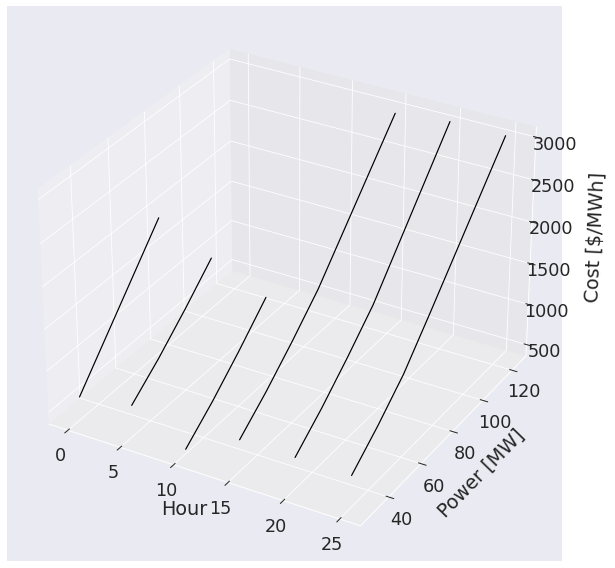

In [13]:
# plot every bid curve over 96 hours
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
costs = bid_profiles_sorted.iloc[:,0:5].to_numpy()
powers = bid_profiles_sorted.iloc[:,5:].to_numpy()
costs = np.array([costs[i][~np.isnan(costs[i])] for i in range(len(costs))])
powers = np.array([powers[i][~np.isnan(powers[i])] for i in range(len(powers))])

plt.figure(figsize = (8,8))
t = np.arange(len(times))
ax = plt.subplot(projection='3d')
for t in times:
    costs_plt = costs[t]
    powers_plt = powers[t]
    ax.plot(np.ones(len(costs_plt))*t, powers_plt,costs_plt,color="black")
ax.set_xlabel("Hour")
ax.set_ylabel("\nPower [MW]")
ax.set_zlabel("\n Cost [$/MWh]",linespacing=3.0)
plt.tight_layout()